In [49]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
# Add the datasets you want to analyze in 'dataset_dirnames'
# Change the directory names listed here by the ones set in your data folder.
# In this repository we include an example 'toy_dataset' that can be used to test the notebook.
dataset_dirnames = ['freesound_loops_db_4000'] 
datasets = load_datasets(dirnames=dataset_dirnames, clean=True)  # Load and clean datasets
# Add the datasets you want to analyze in 'methods_to_compare'
methods_to_compare = ['Percival14_essentia', 'Percival14Mod']
%matplotlib inline

# This notebook contains expriments that complement those found in the article: Font, F., & Serra, X. (2016). Tempo Estimation for Music Loops and a Simple Confidence Measure. In Proceedings of the Int. Conf. on Music Information Retrieval (ISMIR).
# License: CC-BY-4.0

In this notebook we compare implementation variations of Percival14's method.
We observed a certain misbehaving for Percival14 results for sounds shorter than 6 seconds. In our original evaluation we zero-padded all sounds shorter than 6 seconds to be at least 6 seconds long (to prevent software crashes). This had however an unexpected positive impact on estimation accuracy as (in authors' original python implementation of the method) the evaluation of pulse trains (see algorithm) worked best if filtered flux signal contains information at the end of the window (which is what was achieved by zero-padding). We revised the python implementation and updated the code (that's what Percival14Mod method represents) to not favour information at the end of the window and to better closely follow the method as described in the paper (probably at the expense of some speed optimisations). Our Essentia implementation of the method [TODO: provide link] also implements the modifications from Percival14Mod.

In this notebook we see how the modified version is robust to sound length (Fig. 2) and slightly increases overall performance (Fig. 1, Fig. 3). 

## General accuracy



General tempo estimation results (FSL4)
****************************************


Method                Accuracy 1e   Accuracy 1   Accuracy 2   N      
---------------------------------------------------------------------
Percival14Mod         47.95         57.76        71.31        3942   
Percival14_essentia   45.07         55.61        68.47        3949   


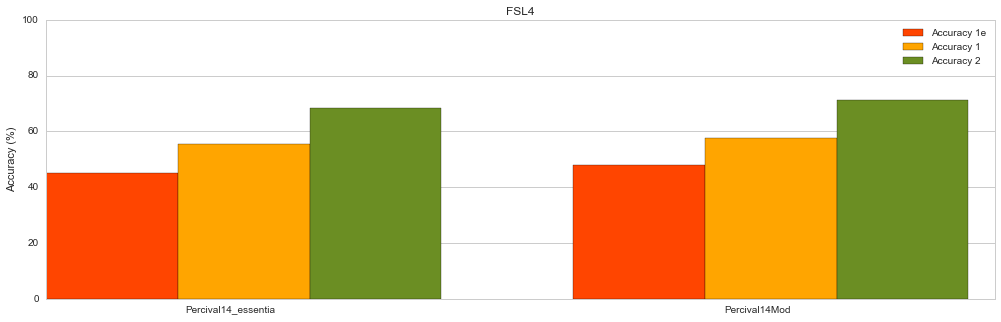


**Figure 1**: Overall tempo estimation accuracies.



General tempo estimation results (ALL DATASETS)
-----------------------------------------------

Method                Accuracy 1e   Accuracy 1   Accuracy 2   Mean accuracy   
------------------------------------------------------------------------------
Percival14Mod         47.95         57.76        71.31        59.01           
Percival14_essentia   45.07         55.61        68.47        56.39           


In [50]:
# Prepare figure
n_datasets = len(datasets)
if not n_datasets:
    raise Exception("No datasets were specified or could be loaded!")
nrows = int(math.ceil(float(n_datasets)/2))
ncols = 1 if n_datasets < 2 else 2
fig1, axs = plt.subplots(nrows, ncols, figsize=(17, 5))

# Run analysis and plot results
all_datasets_method_results = dict()
for count, dataset in enumerate(datasets):
    print title("\nGeneral tempo estimation results (%s)" % dataset.short_name, c='*')
    methods_to_compare = methods_to_compare
      
    table_header = ['Method', 'Accuracy 1e', 'Accuracy 1', 'Accuracy 2', 'N']
    table_rows = list()
    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = dict()
        try:
            table_row = [method]
            for accuracy_func in accuracy1e, accuracy1, accuracy2:
                method_results = accuracy_func(dataset.data, method,skip_zeroed_values=True)
                table_row.append(100 * basic_statistics(method_results)['avg'])
                if accuracy_func.__name__ not in all_datasets_method_results[method]:
                    all_datasets_method_results[method][accuracy_func.__name__] = list()
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
            table_row.append(len(method_results))
            table_rows.append(table_row)
        except IndexError:
            print "Warning: Skipping method %s (analsyis not found in dataset)" % method
            continue
    print ""
    print_table(table_header, table_rows, sort_column=3, highlight_max=True)
    
    if n_datasets == 1:
        ax = axs
    elif n_datasets == 2:
        ax = axs[count]
    else:
        ax_col=count/2
        ax_row=count%2
        ax = axs[ax_col,ax_row]
        
    N = len(methods_to_compare)
    ind = np.arange(N)
    accuracy_1e_means = [row[1] for row in table_rows]
    accuracy_1_means = [row[2] for row in table_rows]
    accuracy_2_means = [row[3] for row in table_rows]
    width = 0.25
    rects1 = ax.bar(ind, accuracy_1e_means, width, color=COLORS[0])
    rects2 = ax.bar(ind + width, accuracy_1_means, width, color=COLORS[1])
    rects3 = ax.bar(ind + 2*width, accuracy_2_means, width, color=COLORS[2])
    ax.set_title(dataset.short_name)
    ax.set_xticks(ind + 1.4 * width)
    ax.set_xticklabels([method for method in methods_to_compare], rotation=0)
    ax.legend((rects1[0], rects2[0], rects3[0]), ('Accuracy 1e', 'Accuracy 1', 'Accuracy 2'))
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)
    
plt.show()
figure_caption = """
**Figure 1**: Overall tempo estimation accuracies.
"""
IPython.display.display(IPython.display.Markdown(figure_caption))

# Show results for all datasets combined
print title("General tempo estimation results (ALL DATASETS)")
table_header = ['Method', 'Accuracy 1e', 'Accuracy 1', 'Accuracy 2', 'Mean accuracy']
table_rows = list()
for method, results in all_datasets_method_results.items():
    table_row = [method]
    for accuracy_measure, data in results.items():
        table_row.append(100 * basic_statistics(data)['avg'])
    table_rows.append(table_row + [np.mean(table_row[1:])])
print_table(table_header, table_rows, sort_column=4, highlight_max=True)

## Accuracy vs sound duration


Duration vs tempo estimation accuracy (FSL4)
--------------------------------------------



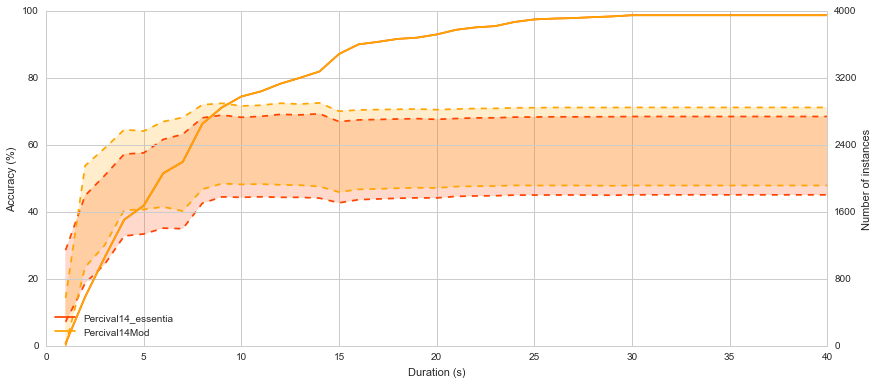

**Figure 2 - FSL4 **: Accuracy vs duration for FSL4 dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    

In [51]:
for dataset in datasets:
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
    ax2 = ax1.twinx()

    for count, method in enumerate(methods_to_compare):
        accuracies_1e = list()
        accuracies_1 = list()
        accuracies_2 = list()
        counts = list()
        steps = np.linspace(1, 40, 40)
        for duration_max in steps:
            try:
                filtered_data = dataset.filter_data([('analysis.durations.duration__<=', duration_max)]).data
                accuracies_1e.append(100 * basic_statistics(accuracy1e(filtered_data, method))['avg'])
                accuracies_1.append(100 * basic_statistics(accuracy1(filtered_data, method))['avg'])
                accuracies_2.append(100 * basic_statistics(accuracy2(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
                
        ax1.plot(steps, accuracies_1e, color=COLORS[count], ls="--")
        ax1.plot(steps, accuracies_2, color=COLORS[count], ls="--")
        ax1.fill_between(steps, accuracies_1e, accuracies_2, color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label=method)

    print title('Duration vs tempo estimation accuracy (%s)' % dataset.short_name)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('Duration (s)')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    plt.show()
    figure_caption = """**Figure 2 - %s **: Accuracy vs duration for %s dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    """ % (dataset.short_name, dataset.short_name)
    IPython.display.display(IPython.display.Markdown(figure_caption))

## Accuracy vs confidence measure

In [52]:
# Confidence measure function
# NOTE: to speed up this process here we have already precomputed the effective start and end positions 
# acocrding to the envelope
def compute_confidence_measure(estimated_bpm,
                       duration_samples,
                       start_effective_duration,
                       end_effective_duration,
                       sample_rate=44100, beat_range=range(1, 128), k=0.5):
    if estimated_bpm == 0:
        # This condition is to skip computing other steps if estimated bpm is 0, we already know that the
        # output will be 0
        return 0

    durations_to_check = [
        duration_samples,
        duration_samples - start_effective_duration,
        end_effective_duration,
        end_effective_duration - start_effective_duration
    ]

    beat_duration = (60.0 * sample_rate)/estimated_bpm
    L = [beat_duration * n for n in beat_range]
    thr_lambda = k * beat_duration
    confidences = list()
    for duration in durations_to_check:
        delta_l = min([abs(l - duration) for l in L])
        if delta_l > thr_lambda:
            confidences.append(0.0)
        else:
            confidences.append(1.0 - float(delta_l) / thr_lambda)
    return max(confidences)

# Iterate over all instances in all datasets and for all methods
print 'Computing confidence measure values for all sounds in all datasets and for all methods...',
n_annotated = 0
for dataset in datasets:
    for key, item in dataset.data.items():
        for method in methods_to_compare:
            try:
                item['analysis'][method]['confidence_ffont'] = compute_confidence_measure(
                    int(round(item['analysis'][method]['bpm'])),  
                    item['analysis']['durations']['length_samples'],
                    item['analysis']['durations']['start_effective_duration'], 
                    item['analysis']['durations']['end_effective_duration']
                )
                n_annotated += 1
            except KeyError:
                continue
print 'done! \n%i annotations done' % n_annotated
if n_annotated == 0:
    print 'It looks like no instances have been annotated. Make sure that the dataset has been properly analysed.'

Computing confidence measure values for all sounds in all datasets and for all methods... done! 
7891 annotations done



Confidence vs tempo estimation accuracy (FSL4)
----------------------------------------------



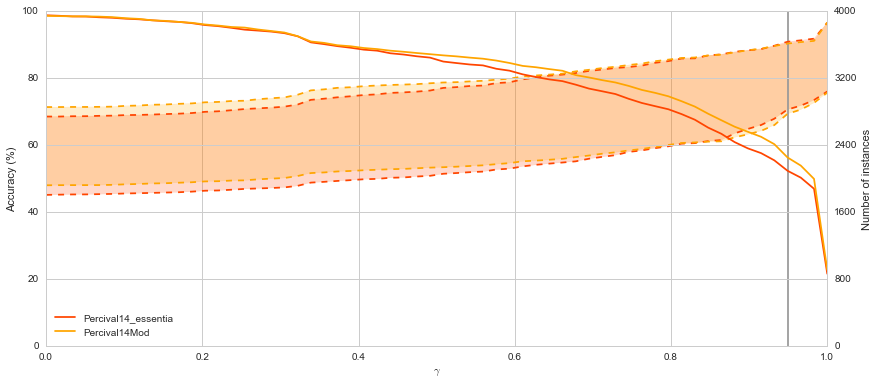

**Figure 3 - FSL4 **: Accuracy vs confidence measure for FSL4 dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    

In [53]:
# Now do all the plotting

for dataset in datasets:
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
    ax2 = ax1.twinx()

    for count, method in enumerate(methods_to_compare):
        accuracies_1e = list()
        accuracies_1 = list()
        accuracies_2 = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            try:
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_min)]).data
                accuracies_1e.append(100 * basic_statistics(accuracy1e(filtered_data, method))['avg'])
                accuracies_1.append(100 * basic_statistics(accuracy1(filtered_data, method))['avg'])
                accuracies_2.append(100 * basic_statistics(accuracy2(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
                
        ax1.plot(steps, accuracies_1e, color=COLORS[count], ls="--")
        ax1.plot(steps, accuracies_2, color=COLORS[count], ls="--")
        ax1.fill_between(steps, accuracies_1e, accuracies_2, color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label=method)

    print title('Confidence vs tempo estimation accuracy (%s)' % dataset.short_name)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax1.vlines(0.95, 0, 100, color='#999999')  # 95% confidence threshold
    plt.show()
    figure_caption = """**Figure 3 - %s **: Accuracy vs confidence measure for %s dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    """ % (dataset.short_name, dataset.short_name)
    IPython.display.display(IPython.display.Markdown(figure_caption))

### Accuracy results for confidence > 95%, 100%

In [54]:
# Accuracy for for confidence threshold > 95%
conf_threshold = 0.95
table_header = ['Method'] + [dataset.short_name for dataset in datasets]
table_rows = list()
for method in methods_to_compare:
    table_row = list()
    table_row.append(method)
    for dataset in datasets:
        try:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_threshold)]).data
            min_acc = 100 * basic_statistics(accuracy1e(filtered_data, method))['avg']
            max_acc = 100 * basic_statistics(accuracy2(filtered_data, method))['avg']
        except IndexError:
            print 'Unable to compute results for method %s and dataset %s' % (method, dataset.short_name)
            table_row.append('-')
            continue
        table_row.append('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
    table_rows.append(table_row)
print title('\nConfidence threshold %.2f' % conf_threshold)
print_table(table_header, table_rows)

# Accuracy for for confidence threshold = 100%
conf_threshold = 1.00
table_header = ['Method'] + [dataset.short_name for dataset in datasets]
table_rows = list()
for method in methods_to_compare:
    table_row = list()
    table_row.append(method)
    for dataset in datasets:
        try:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_threshold)]).data
            min_acc = 100 * basic_statistics(accuracy1e(filtered_data, method))['avg']
            max_acc = 100 * basic_statistics(accuracy2(filtered_data, method))['avg']
        except IndexError:
            print 'Unable to compute results for method %s and dataset %s' % (method, dataset.short_name)
            table_row.append('-')
            continue
        table_row.append('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
    table_rows.append(table_row)
print title('\nConfidence threshold %.2f' % conf_threshold)
print_table(table_header, table_rows)



Confidence threshold 0.95
--------------------------

Method                FSL4                      
------------------------------------------------
Percival14_essentia   A=70.64 - 90.80%, N=53%   
Percival14Mod         A=69.29 - 90.27%, N=57%   


Confidence threshold 1.00
--------------------------

Method                FSL4                      
------------------------------------------------
Percival14_essentia   A=75.96 - 96.52%, N=22%   
Percival14Mod         A=75.61 - 96.58%, N=23%   
